In [1]:
from facenet_pytorch import MTCNN
import cv2
import math
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
from tqdm.notebook import tqdm
import seaborn as sns
from scipy import stats
import time
import glob
import os
import torch as pt
from torchvision import transforms as trans
from torch import nn
from imutils.video import FileVideoStream
from statistics import mode
import pandas as pd
import time

In [2]:
#### timer

t1 = time.time()


In [3]:
#Load the video
v_cap = cv2.VideoCapture('Data/videoplayback.mp4')
v_len = int(v_cap.get(cv2.CAP_PROP_FRAME_COUNT))
fps = int(v_cap.get(cv2.CAP_PROP_FPS))
timestamps = [] #list for the timestamps


### Face detection part

In [4]:
mtcnn = MTCNN(select_largest=False, device='cuda', keep_all=False,post_process=False, image_size=48)

In [5]:
# Loop through video
batch_size = 2048
batch_num = 0
frames = []
boxes = []
landmarks = []
view_frames = []
view_boxes = []
view_landmarks = []
print(v_len)
sf = 1 # get one frame per second
lff = False # last frame fail flag

for i in tqdm(range(v_len)):
    # Load frame
    success, frame = v_cap.read()
    if i % math.floor(fps)*sf == 0 or i >= v_len-1: #skip to get every sf seconds and get the last frame for processing
        success, frame = v_cap.retrieve()
    else:
        continue
    if not success and i < v_len-1:
        continue
    else:
        if i >= v_len-1: #in case is the last frame and it failed
            lff = True

    if not lff:
        # Add to batch, resizing for speed
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame = Image.fromarray(frame)
        frame = frame.resize([int(f * 0.25) for f in frame.size])
        frames.append(frame)
        timestamps.append(math.floor(v_cap.get(cv2.CAP_PROP_POS_MSEC))//1000) #append timestamp of the frame
    
    # When batch is full, detect faces and reset batch list
    if len(frames) >= batch_size or i >= v_len-1:
        print("MTCNN batch num" + str(batch_num) + " from:" + str(timestamps[0]) + " to:" + str(timestamps[-1:]))
        #define save path 
        save_paths = [f'Data/T4/{timestamps[i]}.jpg' for i in range(len(frames))]
        faces = mtcnn(frames, save_path=save_paths)
        im_count = 0
        batch_num += 1
        frames = [] #clear frame list
        timestamps = [] #clear timestamplist
        
    outi = i

282387


  0%|          | 0/282387 [00:00<?, ?it/s]

MTCNN batch num0 from:0 to:[1980]


C:\Users\Raphael\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"
C:\Users\Raphael\AppData\Local\Programs\Python\Python310\lib\site-packages\facenet_pytorch\models\utils\detect_face.py:183: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  batch_boxes, batch_points = np.array(batch_boxes), np.array(batch_points)
C:\Users\Raphael\AppData\Local\Programs\Python\Python310\lib\site-packages\facenet_pytorch\models\mtcnn.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (wh

MTCNN batch num1 from:1981 to:[3962]
MTCNN batch num2 from:3963 to:[5944]
MTCNN batch num3 from:5945 to:[7925]
MTCNN batch num4 from:7926 to:[9421]


In [6]:
t2 = time.time()
delta1 = t2-t1

print(delta1)

195.838458776474


### Emotion detection part

In [7]:
#0 - happy
#1 - sad
#2 - neutral
images = []
time_stamps=[]
for i in range(10): #to deal with OSError: [Errno 24] Too many open files: 'Data/T4\\8484.jpg'
    filelist = glob.glob(f'Data/T4/{i}*')
    for f in filelist:
        time_stamp=int(os.path.split(f)[1].split('.')[0])
        time_stamps.append(time_stamp)

    imagestmp = [Image.open(f).copy() for f in filelist]
    images = images+imagestmp
np_time_stamps=np.array(time_stamps)
np_images=np.array(images)

C:\Users\Raphael\AppData\Local\Temp\ipykernel_7932\3496881956.py:15: FutureWarning: The input object of type 'Image' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Image', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  np_images=np.array(images)
C:\Users\Raphael\AppData\Local\Temp\ipykernel_7932\3496881956.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np_images=np.array(images)


In [8]:
class EmotionDetector(nn.Module):
    def __init__(self, in_ch,classes):
        super(EmotionDetector,self).__init__()

        self.conv1=nn.Conv2d(in_channels=in_ch,out_channels=60, kernel_size=(3,3))
        self.relu1=nn.ReLU()
        self.bn1=nn.BatchNorm2d(60)
        self.maxPool1=nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))


        self.conv2=nn.Conv2d(in_channels=60,out_channels=120, kernel_size=(3,3))
        self.relu2=nn.ReLU()
        self.bn2=nn.BatchNorm2d(120)
        self.maxPool2=nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))


        self.conv3=nn.Conv2d(in_channels=120,out_channels=240, kernel_size=(3,3))
        self.relu3=nn.ReLU()
        self.bn3=nn.BatchNorm2d(240)
        # self.maxPool3=nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))
        #28*28*1 -> 27-13-> 12-6 *80 -> 5*4*100
        #    
        self.dropout=nn.Dropout2d()

        self.conv4=nn.Conv2d(in_channels=240,out_channels=480, kernel_size=(3,3))
        self.relu4=nn.ReLU()
        self.maxPool4=nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))



        # self.conv5=nn.Conv2d(in_channels=120,out_channels=150, kernel_size=(5,5))
        # self.relu5=nn.ReLU()
        # self.maxPool5=nn.MaxPool2d(kernel_size=(2,2), stride=(1,1))


        self.fc1=nn.Linear(in_features=480*3*3,out_features=200)
        self.relu_fc1=nn.ReLU()

        self.fc2=nn.Linear(in_features=200,out_features=classes)
        self.lsm=nn.LogSoftmax(dim=1)

    def forward(self,x):
        debug=False
        x=x.float()
        if debug : print("input to cv1 ",x.shape)
        x=self.conv1(x)
        if debug : print("input to mxp1",x.shape)
        x=self.bn1(x)
        x=self.relu1(x)
        x=self.maxPool1(x)
        # x=self.dropout(x)


        if debug :print("input to cv2",x.shape)
        x=self.conv2(x)
        x=self.bn2(x)

        if debug : print("input to mxp2",x.shape)
        x=self.relu2(x)
        x=self.maxPool2(x)
        # x=self.dropout(x)

        if debug : print("input to cv3",x.shape)
        x=self.conv3(x)
        x=self.bn3(x)
        x=self.relu3(x)
        if debug : print("input to mxp3",x.shape)
        # x=self.maxPool3(x)
        x=self.dropout(x)


        x=self.conv4(x)
        x=self.relu4(x)
        x=self.maxPool4(x)
        x=self.dropout(x)
        # x=self.conv5(x)
        # x=self.relu5(x)
        # x=self.maxPool5(x)

        if debug : print("input to fc1",x.shape)
        x = pt.flatten(x,1)

        x=self.fc1(x)
        x=self.relu_fc1(x)
        if debug : print("input to fc2 ",x.shape)
        x=self.fc2(x)
        if debug : print("input to lsm ",x.shape)
        output=self.lsm(x)
        if debug : print("final output ",x.shape)
        return output

In [9]:
MODEL_NAME= 'EMOTION_DETECTOR_1.pt'
MODEL_PATH = f"models//{MODEL_NAME}" 
CLASSES=3
model=EmotionDetector(in_ch=1,classes=CLASSES).to('cuda')
model.load_state_dict(pt.load(MODEL_PATH))

<All keys matched successfully>

In [10]:
print(len(np_images))
output_emo=[]
model.eval()
with pt.no_grad():
    for image, times in zip(np_images,np_time_stamps):
      image2 = Image.fromarray(np.uint8(image)).convert('L')
      img = trans.ToTensor()(image2).type(pt.FloatTensor).to("cuda").reshape(1,1,48,48)
      pred=pt.exp(model(img))
      idx=pred.argmax(axis=1).cpu().numpy()[0]
      output_emo.append(idx)

9287


In [11]:
print(output_emo[1:50])
print(time_stamps[-1:])
np_emo=np.array(output_emo)
np_ts=np.array(time_stamps)



[2, 0, 2, 2, 2, 2, 2, 0, 2, 2, 0, 0, 0, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 0, 2, 0, 0, 2, 0, 0, 2, 2, 2, 0, 2, 2, 0, 2, 2, 2, 2, 2, 0, 1, 2, 2]
[999]


In [12]:
#sort lists

sEmotion = Z = [x for _,x in sorted(zip(time_stamps,output_emo))]
sTime = time_stamps
sTime.sort()

### Data Viz part

#set graph shape
sns.set(rc={'figure.figsize':(20,2)})

i =0
#every 1 min get mode
step =60
#new time stamps every element represent a minute
ticks=[]
emotion_min=[]
min=0
while i +step < len(np_emo):
  #dont panic, jsut calculating the mode,
  #returns a tuple of lists get first e from tuple then first from list
  emotion_min.append(stats.mode(np_emo[i:i+step])[0][0])
  ticks.append(min)
  min+=1
  i=i+step

import pandas as pd
df=pd.DataFrame()
df['emotion']=emotion_min
df['time_Stamps']=ticks
df.head()

#sns.set(rc={'figure.figsize':(16,5)})
sns.histplot(data=df, x='time_Stamps', hue='emotion', multiple='fill')

df

df=pd.DataFrame()
df['emotion']=output_emo
df['time_Stamps']=time_stamps
df.head()

df.to_csv('emotions.csv')

#sns.set(rc={'figure.figsize':(16,5)})
sns.histplot(data=df, x='time_Stamps', hue='emotion', multiple='fill')

#### Viz with mode 2

def percentageEvaluationMode(value_list, timestamp_list, sliceSize):
    outputList = []
    timestamps = []
    partitionSize = math.floor(len(value_list)/sliceSize)
    #print(partitionSize)

    for i in range(sliceSize):
        #print(partitionSize*i)
        #print(partitionSize*(i+1))
        outputList.append(mode(value_list[partitionSize*i:partitionSize*(i+1)]))
        timestamps.append(timestamp_list[partitionSize*i])
    return outputList, timestamps

normalizedEmotions, normalizedTimes = percentageEvaluationMode(output_emo, time_stamps, 100)

df2 = pd.DataFrame()

df2['emotion']=normalizedEmotions
df2['time_Stamps']=normalizedTimes

sns.histplot(data=df2, x='time_Stamps', hue='emotion', multiple='fill')

#### Sum Viz

def percentageEvaluationSum(value_list, timestamp_list, sliceSize):
    outputListHappy = []
    outputListSad = []
    timestamps = []
    partitionSize = math.floor(len(value_list)/sliceSize)
    print(partitionSize)
    for i in range(sliceSize):
        happy_cnt = 0
        sad_cnt = 0
        for j in range(partitionSize*i, partitionSize*(i+1)):
            if value_list[j] == 0:
                happy_cnt += 1
            if value_list[j] == 1:
                sad_cnt += 1
        
        outputListHappy.append(happy_cnt)
        outputListSad.append(sad_cnt)
        
        timestamps.append(timestamp_list[partitionSize*i])
    return outputListHappy, outputListSad , timestamps

normHappy, normSad, normalizedTimes = percentageEvaluationSum(output_emo, time_stamps, 100)

df3 = pd.DataFrame()
df3['happy'] = normHappy
df3['sad'] = normSad
df3['Time'] = normalizedTimes

df3.set_index('Time')

df3 =df3.melt('Time', var_name='emotion', value_name='value')

df3

sns.set(rc={'figure.figsize':(20,2)})
sns.lineplot(data=df3, x='Time', y='value', hue='emotion')

#### Overall emotioness

normHappy, normSad, normalizedTimes = percentageEvaluationSum(output_emo, time_stamps, 20)

df4 = pd.DataFrame()
df4['emotioness'] = [x + y for x, y in zip(normHappy, normSad)]
df4['time'] = normalizedTimes

df4 = df4.set_index('time')

sns.set(rc={'figure.figsize':(20,2)})
sns.lineplot(data=df4, x='time', y='emotioness')

sns.set(rc={'figure.figsize':(20,2)})

type(normHappy)

df4 =  df4.transpose()

ax = sns.heatmap(df4, center=0, cmap='mako')

ax.invert_yaxis()

#### Average emotion

def percentageEvaluationAvg(value_list, timestamp_list, sliceSize):
    outputList = []
    timestamps = []
    partitionSize = math.floor(len(value_list)/sliceSize)
    print(partitionSize)
    for i in range(sliceSize):
        emotion_cnt = 0
        for j in range(partitionSize*i, partitionSize*(i+1)):
            if value_list[j] == 0:
                emotion_cnt += 1
            if value_list[j] == 1:
                emotion_cnt -= 1
        
        outputList.append(emotion_cnt/partitionSize) 
        timestamps.append(timestamp_list[partitionSize*i])
    return outputList , timestamps

avgEmotion, avgTime = percentageEvaluationAvg(output_emo, time_stamps, 50)

df5 = pd.DataFrame()
df5['emotion'] = avgEmotion
df5['time'] = avgTime

df5 = df5.set_index('time')

df5 =  df5.transpose()

ax = sns.heatmap(df5, center=0)

df5 =  df5.transpose()

sns.set(rc={'figure.figsize':(20,2)})
sns.lineplot(data=df5, x='time', y='emotion')

#### Averaged Simplified

def percentageEvaluationAvgS(value_list, timestamp_list, sliceSize):
    outputList = []
    timestamps = []
    partitionSize = math.floor(len(value_list)/sliceSize)
    print(partitionSize)
    for i in range(sliceSize):
        emotion_cnt = 0
        for j in range(partitionSize*i, partitionSize*(i+1)):
            if value_list[j] == 0:
                emotion_cnt += 1
            if value_list[j] == 1:
                emotion_cnt -= 1
        if emotion_cnt/partitionSize > 0.5:
            outputList.append(1)
        else: 
            if emotion_cnt/partitionSize < -0.5:
                outputList.append(-1)
            else:
                outputList.append(0)
        timestamps.append(timestamp_list[partitionSize*i]//60)
    return outputList , timestamps

avgEmotionS, avgTimeS = percentageEvaluationAvgS(sEmotion, sTime, 50)

avgTimeS[-1:]

df6 = pd.DataFrame()
df6['emotion'] = avgEmotionS
df6['time'] = avgTimeS

df6 = df6.set_index('time')

df6 =  df6.transpose()

df6

sns.set(rc={'figure.figsize':(20,1)})
ax = sns.heatmap(df6, center=0)

df6 =  df6.transpose()

df6

sns.set(rc={'figure.figsize':(20,2)})
sns.lineplot(data=df6, x='time', y='emotion')

#### General visualization class

In [13]:
#0 - happy
#1 - sad
#2 - neutral


class visualizeEmotion:
    def __init__(self, emotion_list, timestamps):
        self.emotion_list = emotion_list
        self.timestamps = timestamps
    
    def percentageEvaluationMode(self, value_list, timestamp_list, sliceSize):
        outputList = []
        timestamps = []
        partitionSize = math.floor(len(value_list)/sliceSize)
        #print(partitionSize)

        for i in range(sliceSize):
            #print(partitionSize*i)
            #print(partitionSize*(i+1))
            outputList.append(mode(value_list[partitionSize*i:partitionSize*(i+1)]))
            timestamps.append(timestamp_list[partitionSize*i])
        return outputList, timestamps
    
    def percentageEvaluationAvgT(self, value_list, timestamp_list, sliceSize, th):
        outputList = []
        timestamps = []
        partitionSize = math.floor(len(value_list)/sliceSize)
        print(partitionSize)
        for i in range(sliceSize):
            emotion_cnt = 0
            for j in range(partitionSize*i, partitionSize*(i+1)):
                if value_list[j] == 0:
                    emotion_cnt += 1
                if value_list[j] == 1:
                    emotion_cnt -= 1
            if emotion_cnt/partitionSize > th:
                outputList.append(1)
            else: 
                if emotion_cnt/partitionSize < th*-1:
                    outputList.append(-1)
                else:
                    outputList.append(0)
            timestamps.append(timestamp_list[partitionSize*i]//60)
        return outputList , timestamps
    
    
    def ModeView(self, sliceSize=100, type = 'hist'):
        normalizedEmotions, normalizedTimes = self.percentageEvaluationMode(self.emotion_list, self.timestamps, sliceSize)
        
        df = pd.DataFrame()
        df['emotion']=normalizedEmotions
        df['time_Stamps']=normalizedTimes
        
        sns.set(rc={'figure.figsize':(20,2)})
        
        if type == 'hist':
            sns.histplot(data=df, x='time_Stamps', hue='emotion', multiple='fill')
        else:
            if type == 'line':
                df['emotion'].replace(1,-1) #replaces sad with -1
                df['emotion'].replace(0, 1) #replaces happy with 1
                df['emotion'].replace(2, 0) #replaces neutral with 1
                
                sns.lineplot(data=df, x='time_Stamps', y='emotion')
            else:
                raise ValueError('Supported types are: "hist" and "line"')
    
    def averageThresholdView(self, sliceSize=100, threshold=0.3):
        avgEmotionS, avgTimeS = self.percentageEvaluationAvgT(self.emotion_list, self.timestamps, sliceSize, threshold)
        df = pd.DataFrame()
        df['emotion'] = avgEmotionS
        df['time'] = avgTimeS

        df = df.set_index('time')

        df =  df.transpose()
        
        sns.set(rc={'figure.figsize':(20,1)})
        colors = ["#489FB5", "#EDE7E3", "#FFA62B"]
        ax = sns.heatmap(df, center=0, cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", colors))
        
        df =  df.transpose()
        #sns.lineplot(data=df, x='time', y='emotion')

In [14]:
VE = visualizeEmotion(sEmotion, sTime)

VE.ModeView(20, type='hist')

92


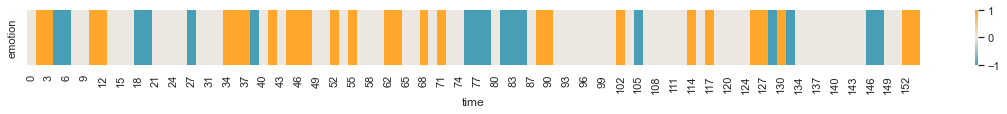

In [18]:
VE.averageThresholdView(100, 0.15)

In [16]:
#### timer

t3 = time.time()

In [17]:
delta2= t3-t1
print(delta2)

212.51931643486023
